In [1]:
import torch
import numpy as np

import os
os.chdir('..')
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load, gen_train_input
from evaluate import evaluate_model, pp_output
import instance_generator as ig
import torch_converter as tc
import evaluate as ev
import osmnx as ox
from util import Dataset
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy
from experiment_parameters import *

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:0


In [3]:
args = {
    'processor':         'GENConv',
    'head':              'regression',     
    'num_layers':        3,
    'num_mlp_layers':    3,
    'aggr':              'max',
    'batch_size':        8,
    'node_feature_dim':  5,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        32,
    'output_dim':        1,
    'dropout':           0.0306,
    'epochs':            64,
    'opt':               'adagrad',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0121,
    'device':            device,
    'noise':             0 # Set to 0 to not train on noisy features
}

## Noise experiments

In [4]:
def create_noise_robust_models(noise_values):
    models = []
    for noise_value in noise_values:
        print(f"Training model for noise {noise_value}")
        args = {
            'processor':         'GENConv',
            'head':              'regression',     
            'num_layers':        3,
            'num_mlp_layers':    3,
            'aggr':              'max',
            'batch_size':        8,
            'node_feature_dim':  5,
            'edge_feature_dim':  1,
            'graph_feature_dim': 2,
            'hidden_dim':        32,
            'output_dim':        1,
            'dropout':           0.0306,
            'epochs':            64,
            'opt':               'adagrad',
            'opt_scheduler':     'none',
            'opt_restart':       0,
            'weight_decay':      5e-3,
            'lr':                0.0121,
            'device':            device,
            'noise':             noise_value # Set to 0 to not train on noisy features
        }


        train_loader, val_loader = gen_train_input(NOISE_ROBUST_MODEL_TRAIN_CONFIG, args, seed=0)
        _, _, _, GNN, _ = train(train_loader, val_loader, args)

        save(GNN, args, f'GNN_noise_{noise_value}')
        models.append((f"GNN_{args['noise']}", GNN))

    return models

In [5]:
# If the models have already been trained, use get_models
def get_models(noise_values):
	models = []
	for noise_value in noise_values:
		GNN, _ = load(f"GNN_noise_{noise_value}", device)
		models.append((f"GNN_{args['noise']}", GNN))
	return models

In [8]:
NOISE_VALUES = np.linspace(0,1,21)
models = create_noise_robust_models(NOISE_VALUES)

# If the models have already been trained, use get_models
# models = get_models(noise_values)

In [ ]:
import gnn_library.util as util
import pickle

num_trials = 100
batch_size = 500
node_configs = EXPERIMENT_NOISE_ROBUSTNESS_REGIMES
graph_configs = ALL_TESTING_GRAPH_CONFIGS

threshold = 0.35
t_greedy = OBM_Threshold_Greedy(threshold) 

rng = np.random.default_rng()

data = [{node_config:[] for node_config in node_configs} for _ in range(len(graph_configs))]
for data_index, graph_config in enumerate(graph_configs):
    print(f"current graph {graph_config}")

    for node_config in node_configs:
        for noise_value, model in zip(NOISE_VALUES, models):
            print(f"Evaluating model for noise {noise_value}")

            args['noise'] = noise_value
            instances = ig.sample_instances(*node_config, num_trials, rng, args, **graph_config)

            cr_ratios, _ = evaluate_model(
                meta_model=None,
                meta_model_type=None,
                base_models=[model[1]],
                instances=instances,
                batch_size=batch_size,
                rng=rng,
                num_realizations=5,
                baselines=['greedy', 'lp_rounding']
            )

            t_greedy_ratio, _ = evaluate_model(
                meta_model=None,
                meta_model_type=None,
                base_models=[t_greedy],
                instances=instances,
                batch_size=batch_size,
                rng=rng,
                num_realizations=5,
            )

            cr_ratios['threshold_greedy'] = t_greedy_ratio['learned']

            data[data_index][node_config].append(cr_ratios)

            with open(f"saved_runs/temp_noise/noise6.pickle", 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
import pickle

with open(f"saved_runs/noise_saved3_6.pickle", 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open(f"saved_runs/noise_saved3_6.pickle", 'rb') as handle:
    data_copy = pickle.load(handle)

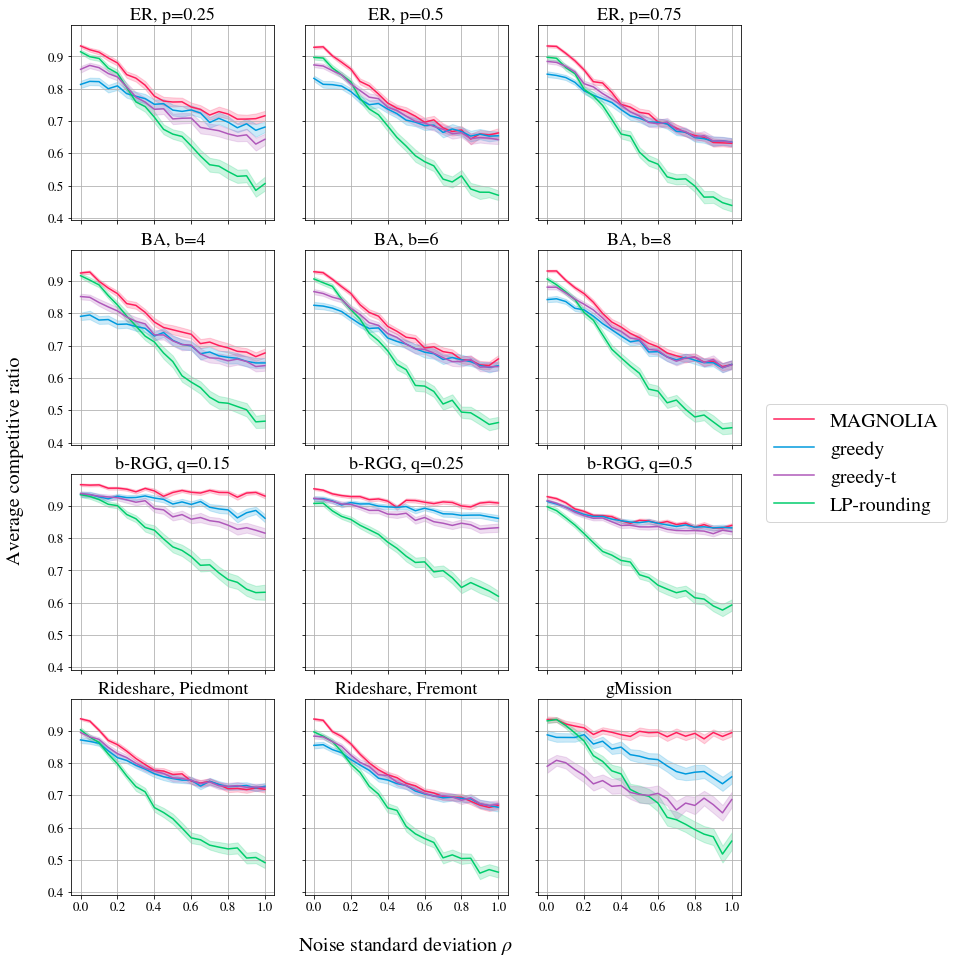

In [94]:
from util import _plot_approx_ratios, _plot_approx_ratios_all
filtered_data = {frozenset(g.items()):d[node_configs[0]] for d,g in zip(data, util.graph_configs_standard)}

_plot_approx_ratios_all(NOISE_VALUES, filtered_data, lambda graph_type: f"noise {graph_config} {node_config[1]}x{node_config[0]}", x_axis_name = "Noise standard deviation $\\rho$", confidence = 0.95)